In [1]:
# taken from https://www.youtube.com/watch?v=VMj-3S1tku0&t=455s
# The spelled-out intro to neural networks and backpropagation: building micrograd

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return x * x - 3 * x + 1

In [3]:
f(2)

-1

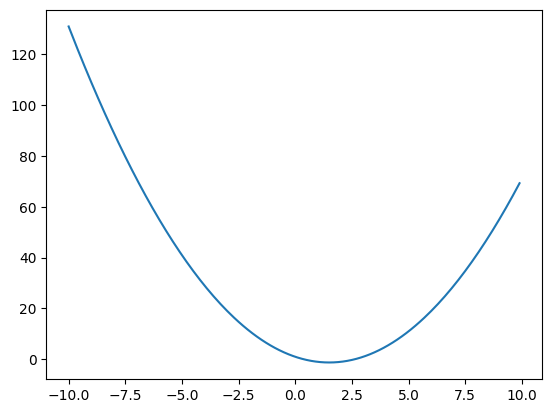

In [4]:
xs = np.arange(-10, 10, 0.1)
ys = f(xs)
plt.plot(xs, ys)

Derivative: How does the function change when we change the input?

In [5]:
h = 0.001
x= 3.0
f(x + h)
(f(x + h) - f(x)) / h

3.0009999999993653

Same can be applied for a function with multiple variables.

You need the local derivative of each node in the graph. Thats all it needs due to the chain rule.

In [6]:
h = 0.0001
a = 3.0
b = -2.0
c  = 5.0
d = a*b+c
a+=h
d2 = a*b+c
print(d)
print(d2)
print((d2-d)/h)


-1.0
-1.0002000000000004
-2.0000000000042206


In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [122]:
class Value:
    def __init__(self, data, _children=None, _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : print("Hello")
        if _children is None:
            _children = tuple()
        self._prev = set(_children)
        self._op=_op
        self.label = label
    def __repr__(self) -> str:
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        print("Adding", self, other)
        out= Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            print("Calling backward while adding on ", out)
            self.grad += 1.0* out.grad
            other.grad += 1.0* out.grad
            
        out._backward = _backward
        
        return out

    def __sub__(self,other):
        return self + other * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        print("Multiplying", self, other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            print("Calling backward while multiplying on", out)
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out

    def __trudediv__(self, other):
        return self * other ** -1


    def __pow__(self, other):
        assert isinstance(other, (float, int))
        
        out = Value(self.data ** other, (self,), "**")
        
        def _backward():
            print("Calling backward while powering on", out)
            self.grad += other * self.data ** (other - 1) * out.grad

    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp")
        
        def _backward():
            print("Calling backward on", out)
            self.grad += out.data * out.grad
        
        out._backward = _backward
        
        return out

    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        out = Value(math.tanh(self.data), (self,), "tanh")
        
        def _backward():
            print("Calling backward on", out)
            self.grad = (1 - out.data**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        # create the topography in the graph starting with inputs
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0
        for node in reversed( topo):
            node._backward()


In [123]:
a = Value(3.0, label="a")
b = Value(-2.0, label="b")
c = Value(5.0, label="c")
f = Value(2.0, label="f")

d = a*b; d.label = "d"

g = f * c; g.label = "g"

e = d - g; e.label = "e"

Multiplying Value(3.0) Value(-2.0)
Multiplying Value(2.0) Value(5.0)
Multiplying Value(10.0) Value(-1)
Adding Value(-6.0) Value(-10.0)


In [114]:
e.backward()

Calling backward while adding on  Value(4.0)
Calling backward while multiplying on Value(10.0)
Hello
Hello
Calling backward while multiplying on Value(-6.0)
Hello
Hello


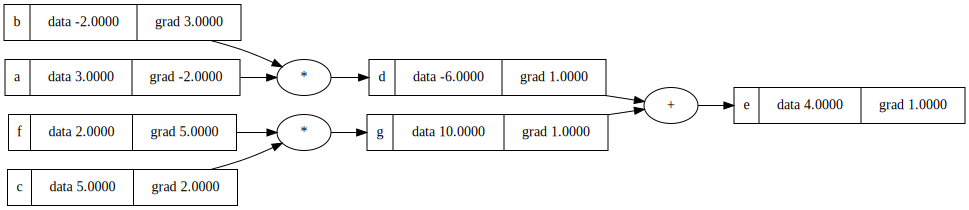

In [115]:
draw_dot(e)

In [91]:
e._backward()
e.grad = 1.0
e._backward()
d._backward()
g._backward()
g._backward()
c._backward()
b._backward()
a._backward()


Calling backward while adding on  Value(4.0)
Calling backward while adding on  Value(4.0)


In [109]:
# create the topography in the graph starting with inputs
e.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
        
build_topo(e)
topo
for node in reversed( topo):
    node._backward()

Calling backward while adding on  Value(4.0)
Calling backward while multiplying on Value(10.0)
Hello
Hello
Calling backward while multiplying on Value(-6.0)
Hello
Hello


In [29]:
a.grad
c.grad

0.0

Multiplying Value(3.0) Value(3.0)
Calling backward while multiplying on Value(9.0)
Hello


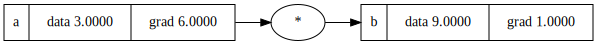

In [120]:
a = Value(3.0, label="a")
b = a*a; b.label = "b"

b.backward()
draw_dot(b)